# Deep Learning with PyTorch : Build a Generative Adversarial Network

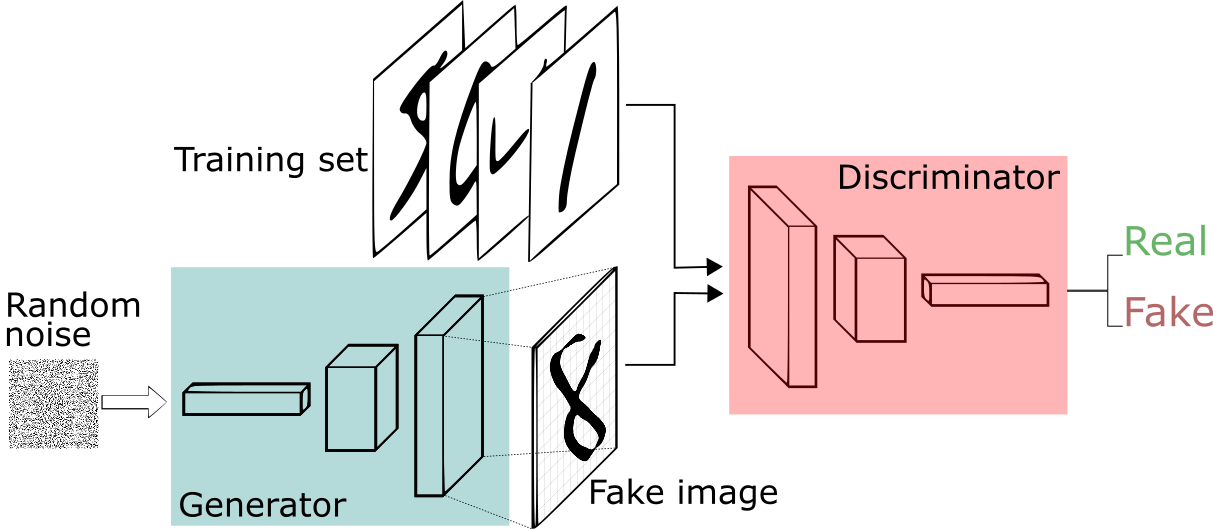

In [2]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

OSError: [WinError 126] The specified module could not be found. Error loading "c:\Users\ashis\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\lib\fbgemm.dll" or one of its dependencies.

# Configurations

In [ ]:
device = 'cuda' # image = image.to(device)
batch_size = 128 # trainloader , training loop
noise_dim = 64 # generator model
# optimizer Parameters
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
#training variables
# epochs = 20

# Load MNIST Dataset

In [ ]:
from torchvision import datasets, transforms as T

In [ ]:
train_augs = T.Compose([T.RandomRotation((-20, +20)),
                        T.ToTensor() # (h,w,c) -> (c , h,w)
                        ])

In [ ]:
trainset = datasets.MNIST('MNIST/', download = True, train = True, transform = train_augs)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4494444.58it/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 133922.18it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1235114.04it/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4894791.56it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



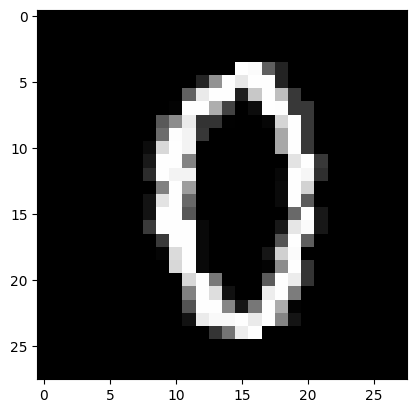

In [ ]:
image , label = trainset[1000]
plt.imshow(image.squeeze(), cmap = 'gray')

In [ ]:
print(" Total image present :" , len(trainset))

 Total image present : 60000


# Load Dataset Into Batches

In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [ ]:
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)

In [ ]:
print("total number of batches in trainloader :" , len(trainloader))

total number of batches in trainloader : 469


In [ ]:
dataitr = iter(trainloader)
images, _ = next(dataitr)
print(images.shape)

torch.Size([128, 1, 28, 28])


In [ ]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

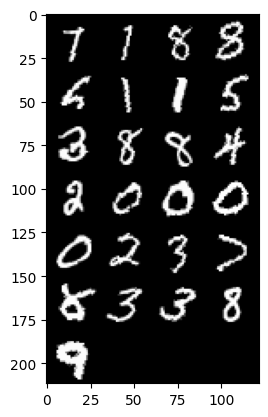

In [ ]:
show_tensor_images(images, num_images = 25)

# Create Discriminator Network

In [ ]:
!pip install torchsummary

In [ ]:
from torch import nn
from torchsummary import summary

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

In [ ]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()

    self.block_1 = get_disc_block(1,16,(3,3),2)
    self.block_2 = get_disc_block(16,32,(5,5),2)
    self.block_3 = get_disc_block(32,64,(5,5),2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features = 64, out_features = 1)

  def forward(self,images):
    x1 = self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.flatten(x3)
    x5 = self.linear(x4)

    return x5


In [ ]:
D = Discriminator()
D.to(device)

summary(D, input_size = (1,28,28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [ ]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator\n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)\n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                                 

In [ ]:
def get_gen_block(in_channels , out_channls, kernel_size, stride, final_block = False):
  if final_block:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channls, kernel_size, stride),
        nn.Tanh()
    )
  else:
    return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channls, kernel_size, stride),
      nn.BatchNorm2d(out_channls),
      nn.ReLU()
  )


In [ ]:
class Generator(nn.Module):
  def __init__(self, z_dim):
    super(Generator,self).__init__()

    self.block_1 = get_gen_block(noise_dim, 256, (3,3), 2)
    self.block_2 = get_gen_block(256, 128, (4,4), 1)
    self.block_3 = get_gen_block(128, 64, (3,3), 2)

    self.block_4 = get_gen_block(64, 1, (4,4), 2, final_block = True)

  def forward(self, r_noise_vec):
      #(bs , noise_dim) -> (bs, noise_dim, 1,1)
      x = r_noise_vec.view(-1, noise_dim, 1, 1)
      x1 = self.block_1(x)
      x2 = self.block_2(x1)
      x3 = self.block_3(x2)
      x4 = self.block_4(x3)

      return x4

In [ ]:
G = Generator(noise_dim)
G.to(device)
summary(G, input_size = (1, noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [ ]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [ ]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, torch.ones_like(disc_pred))
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, torch.zeros_like(disc_pred))
  return loss

In [ ]:
D_opt = torch.optim.Adam(D.parameters(), lr = lr, betas = (beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr = lr, betas = (beta_1, beta_2))
epochs = 50

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 1 | D_loss : 0.6304315700968192 | G_loss : 0.8515524210960372


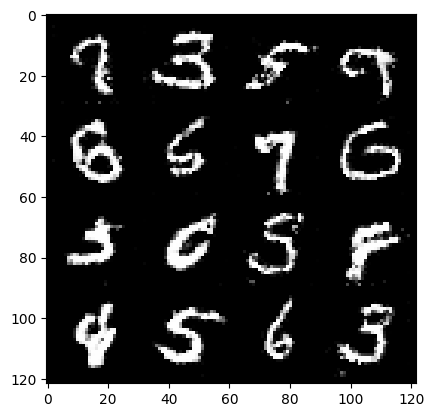

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 2 | D_loss : 0.6312027951039231 | G_loss : 0.85045718041056


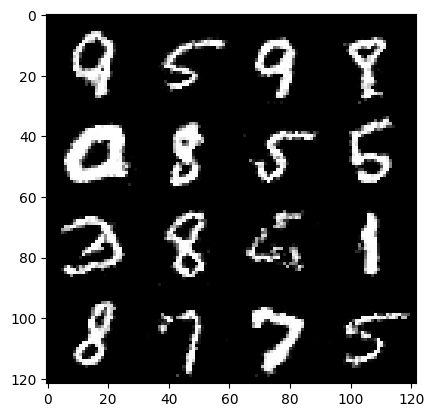

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 3 | D_loss : 0.6312667914290926 | G_loss : 0.8532448088182315


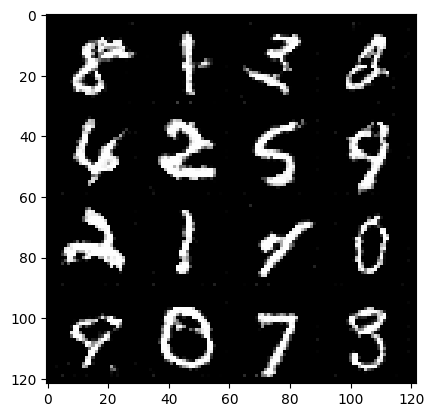

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 4 | D_loss : 0.6289175554379217 | G_loss : 0.8549061840785338


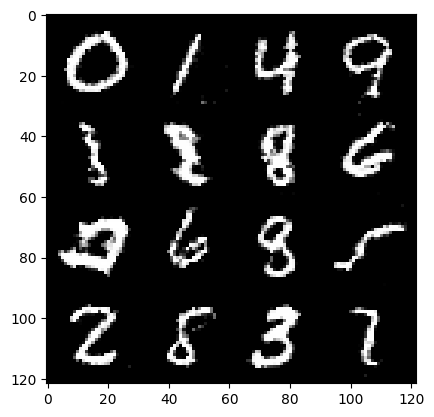

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 5 | D_loss : 0.6299723722278945 | G_loss : 0.8578867729284616


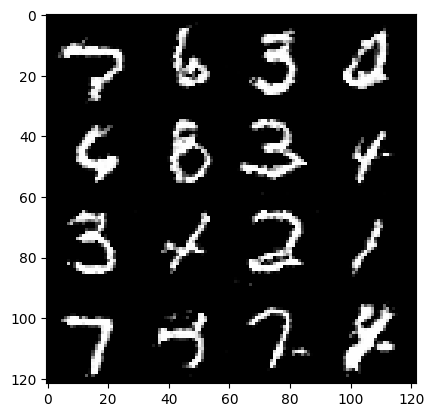

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 6 | D_loss : 0.6294128202171977 | G_loss : 0.8582088982881005


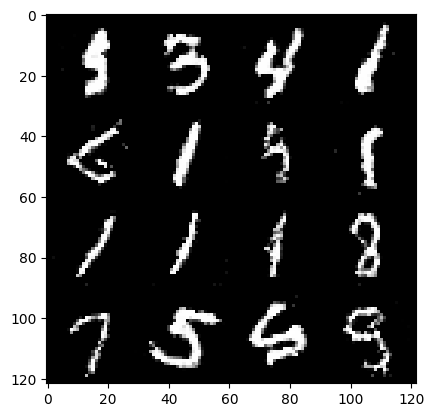

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 7 | D_loss : 0.6296433688226794 | G_loss : 0.8589148825165559


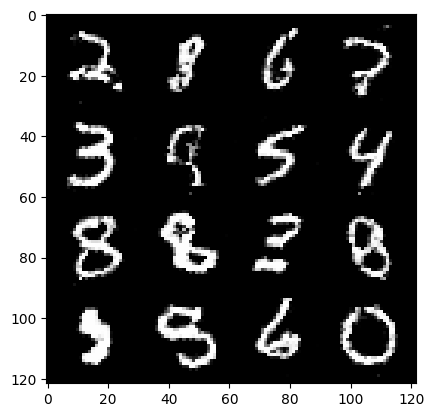

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 8 | D_loss : 0.6284511521426853 | G_loss : 0.8602752669025332


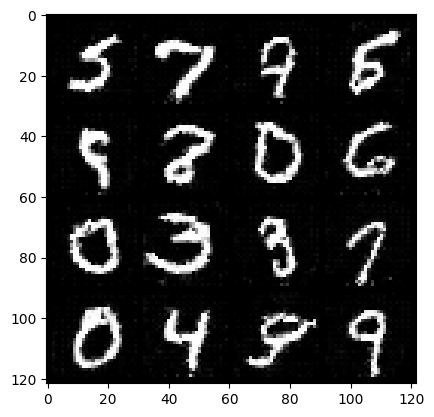

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 9 | D_loss : 0.6260745036068247 | G_loss : 0.8646654496823293


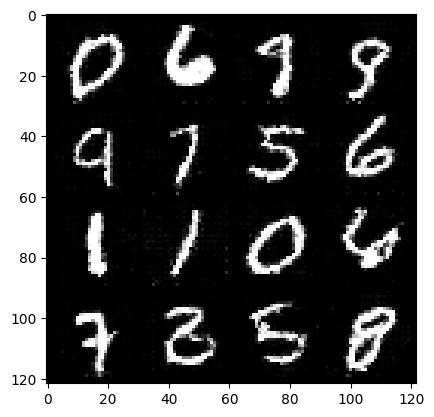

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 10 | D_loss : 0.6241231954682356 | G_loss : 0.8707101341249592


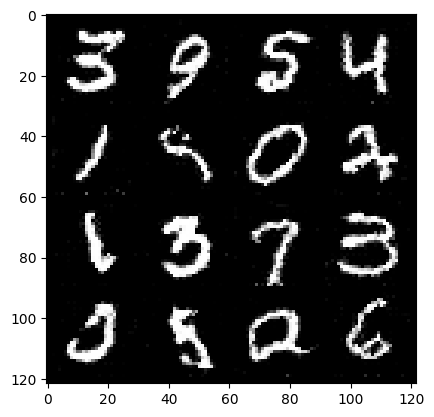

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 11 | D_loss : 0.6246251549039569 | G_loss : 0.8738219985829742


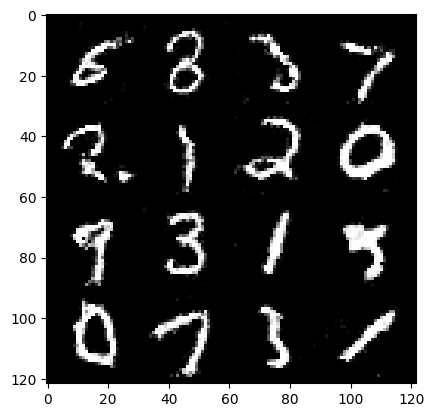

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 12 | D_loss : 0.6216496742610484 | G_loss : 0.8811212404450374


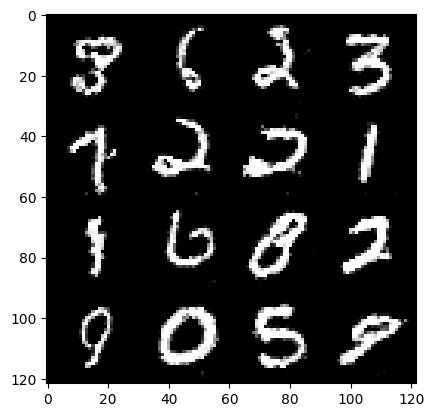

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 13 | D_loss : 0.6210558663553266 | G_loss : 0.8815861911153489


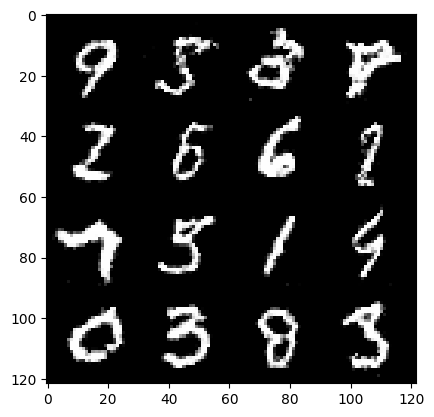

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 14 | D_loss : 0.6192241757154973 | G_loss : 0.8881906867027283


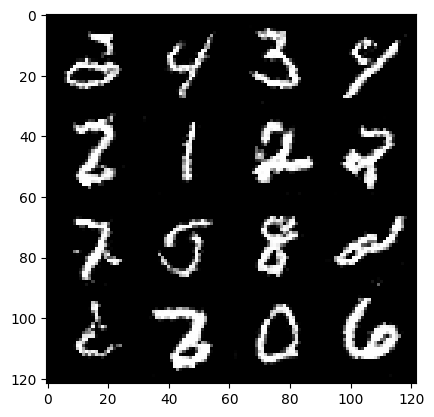

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 15 | D_loss : 0.6188835333913628 | G_loss : 0.8918095117947186


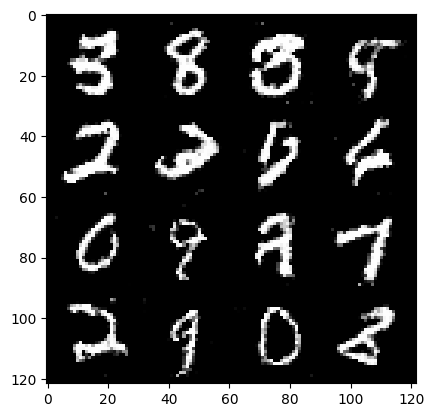

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 16 | D_loss : 0.6168810230836685 | G_loss : 0.8922504325157036


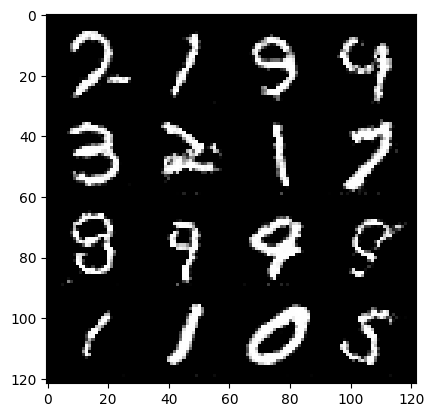

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 17 | D_loss : 0.6163300224967094 | G_loss : 0.8990645381941724


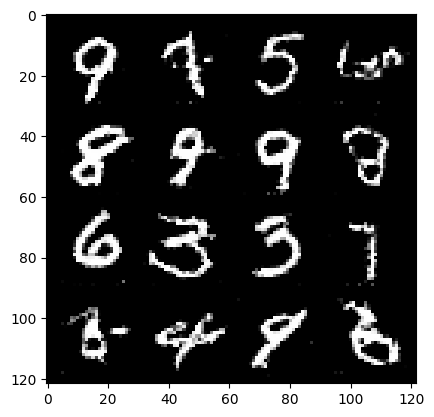

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 18 | D_loss : 0.6174389558560305 | G_loss : 0.9024719336647977


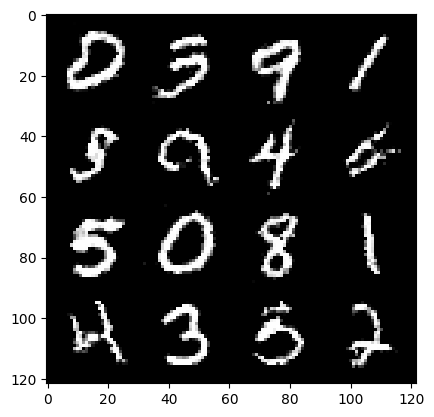

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 19 | D_loss : 0.6148871327005724 | G_loss : 0.9043399653455088


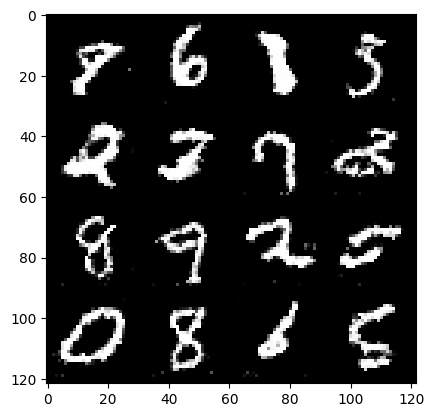

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 20 | D_loss : 0.6145756416229297 | G_loss : 0.9102166718257262


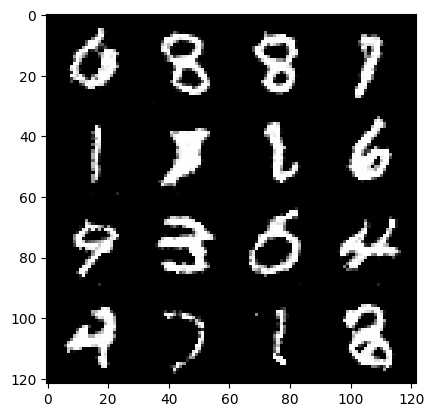

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 21 | D_loss : 0.6119070673293905 | G_loss : 0.9135917080745005


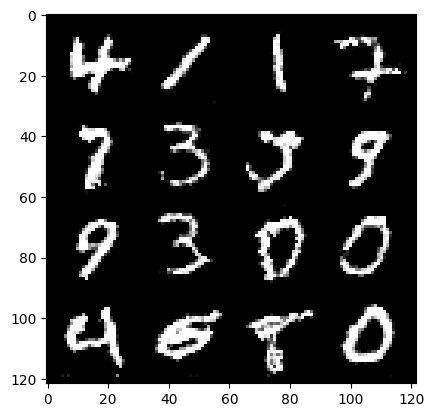

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 22 | D_loss : 0.6102661123153752 | G_loss : 0.9184563925017172


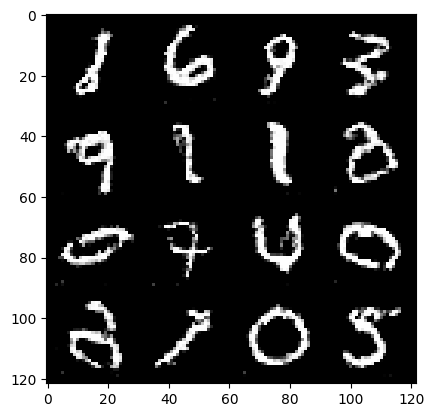

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 23 | D_loss : 0.6119412056672802 | G_loss : 0.9152049767945621


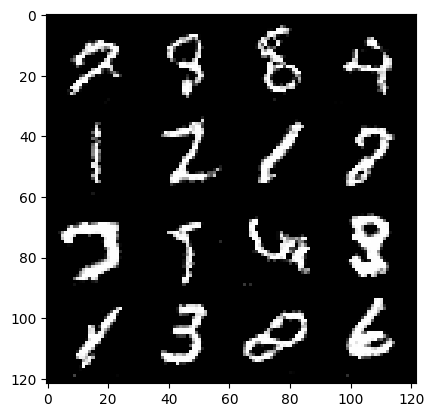

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 24 | D_loss : 0.6100309646205861 | G_loss : 0.9223040030963385


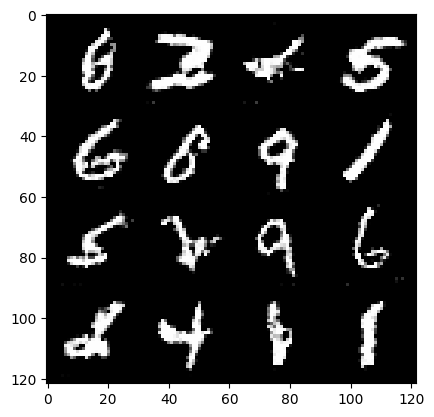

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 25 | D_loss : 0.6102698705852159 | G_loss : 0.9211082673276157


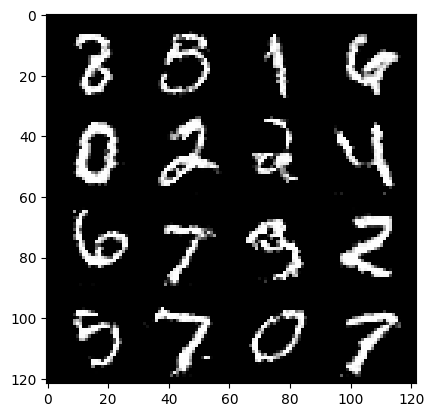

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 26 | D_loss : 0.6105346595808896 | G_loss : 0.9324434431376996


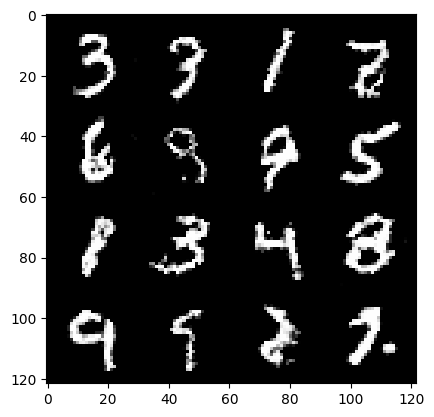

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 27 | D_loss : 0.6102813067975075 | G_loss : 0.9253993221183321


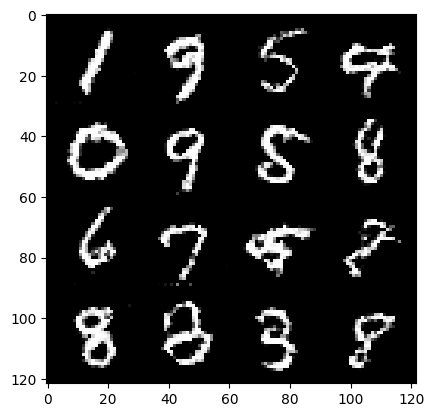

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 28 | D_loss : 0.6081604891494393 | G_loss : 0.9268141556650337


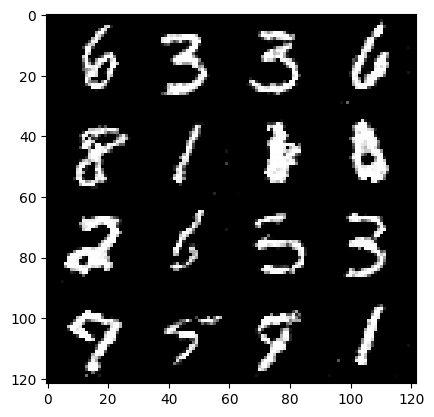

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 29 | D_loss : 0.6114327591111157 | G_loss : 0.9290213628110092


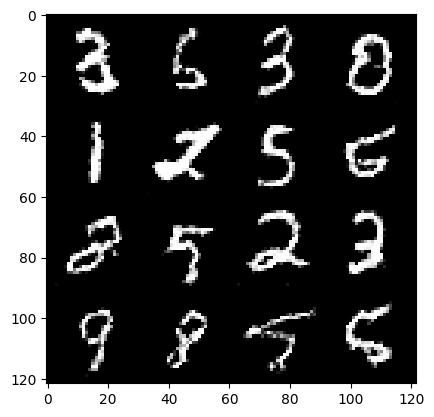

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 30 | D_loss : 0.6081933956156408 | G_loss : 0.9314576440782689


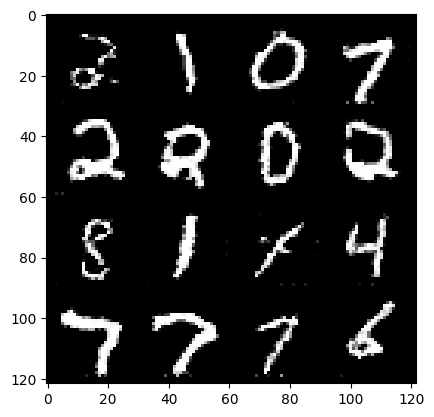

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 31 | D_loss : 0.6109441026949933 | G_loss : 0.9357013666807715


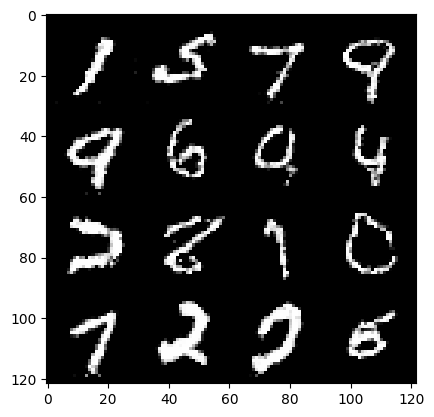

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 32 | D_loss : 0.6078932944899683 | G_loss : 0.9353331054197446


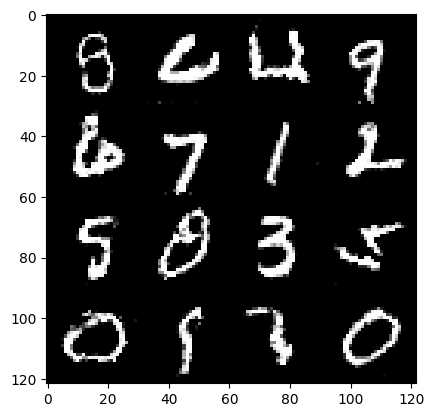

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 33 | D_loss : 0.6092404845172662 | G_loss : 0.9360708471046073


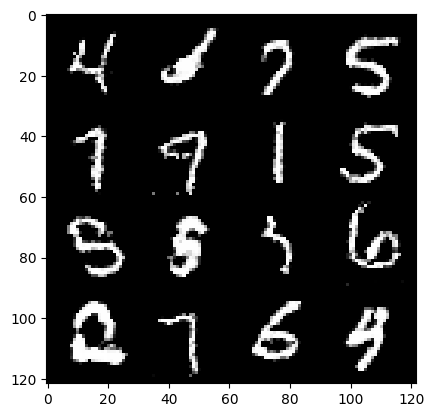

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 34 | D_loss : 0.6083648443730401 | G_loss : 0.9354432682747017


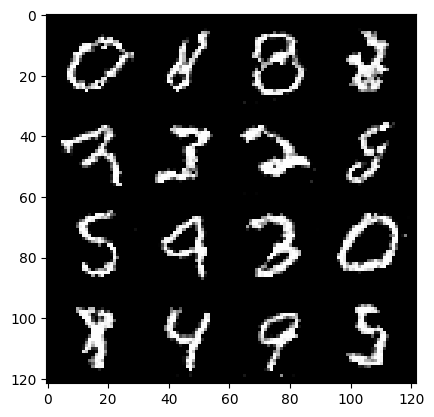

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 35 | D_loss : 0.6098019659900462 | G_loss : 0.9426117242018043


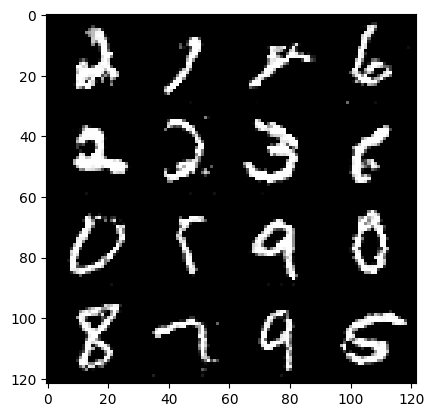

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 36 | D_loss : 0.6074966709496878 | G_loss : 0.9410573411852058


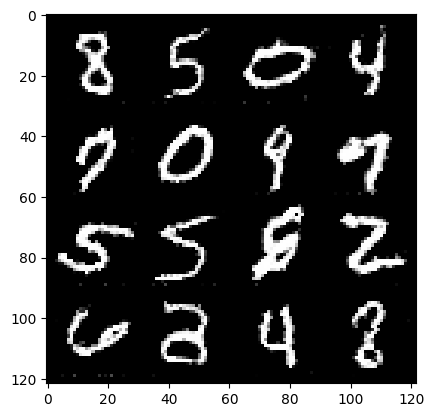

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 37 | D_loss : 0.6084656846294525 | G_loss : 0.9387648109434001


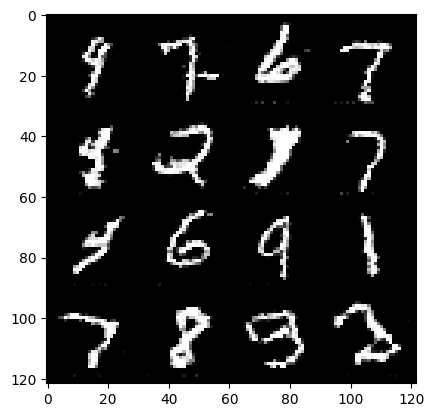

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 38 | D_loss : 0.6100917487764663 | G_loss : 0.9359471156144701


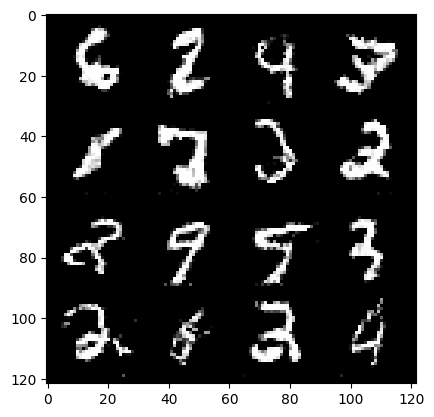

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 39 | D_loss : 0.6098126902509091 | G_loss : 0.933050492297866


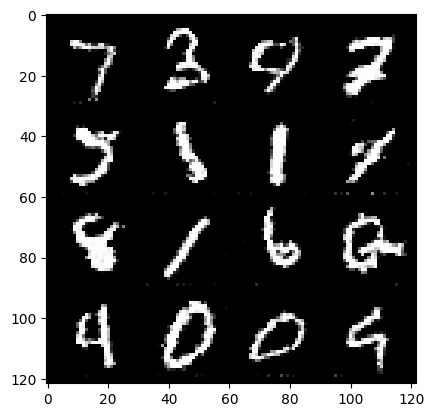

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 40 | D_loss : 0.6085049147799071 | G_loss : 0.946123838170505


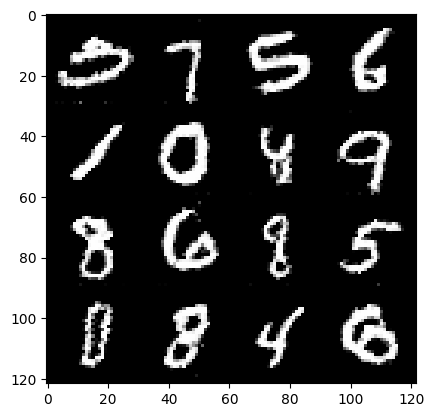

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 41 | D_loss : 0.6082101496043744 | G_loss : 0.9499315245827632


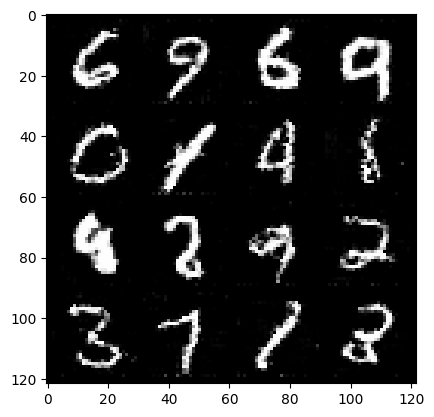

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 42 | D_loss : 0.6119184787593671 | G_loss : 0.9395112127129203


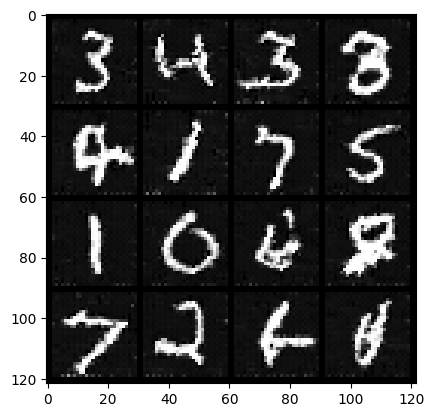

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 43 | D_loss : 0.6078632799292932 | G_loss : 0.9391593700532974


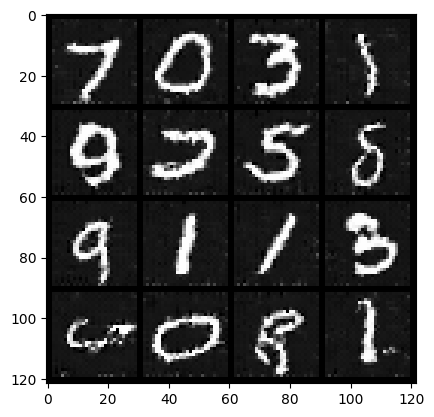

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 44 | D_loss : 0.6105076392322207 | G_loss : 0.9430371862230524


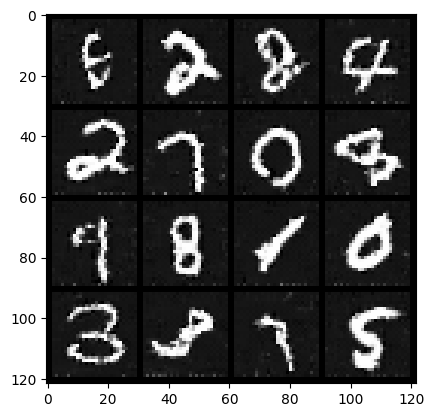

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 45 | D_loss : 0.6094965339977858 | G_loss : 0.9470085299599653


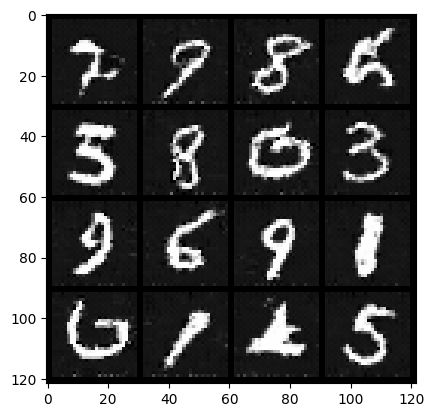

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 46 | D_loss : 0.6122864713546818 | G_loss : 0.9345244760198126


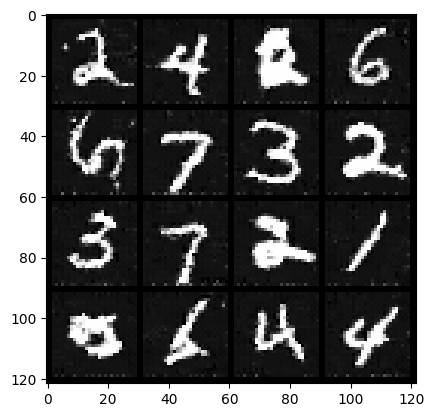

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 47 | D_loss : 0.6097453339521819 | G_loss : 0.946131194578305


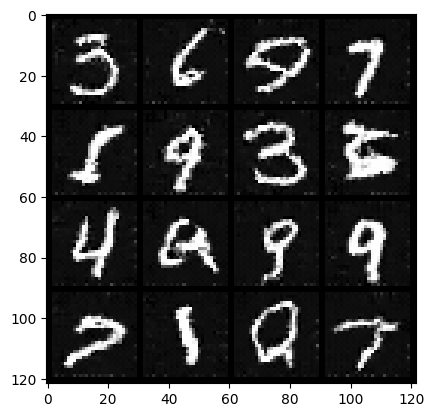

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 48 | D_loss : 0.6113815064877589 | G_loss : 0.9412155763935178


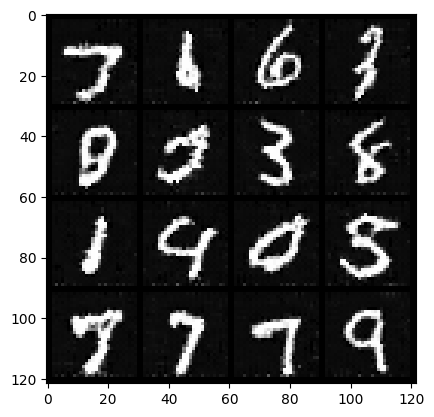

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 49 | D_loss : 0.6108067409316106 | G_loss : 0.940920170182104


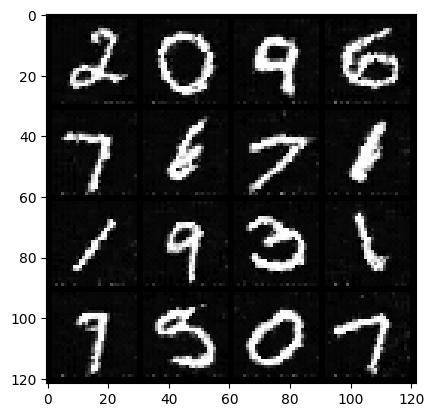

  0%|          | 0/469 [00:00<?, ?it/s]

Epochs: 50 | D_loss : 0.6108122488328898 | G_loss : 0.942972193775909


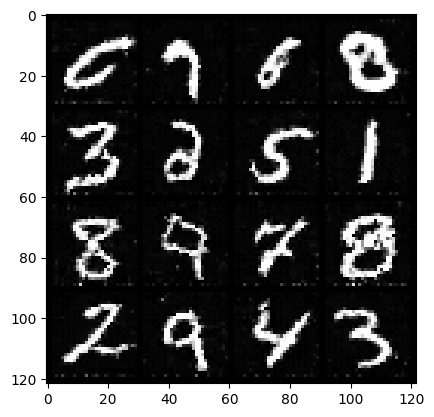

In [ ]:
for i in range(epochs):
  # print("Epoch : ", i)
  total_d_loss = 0.0
  total_g_loss = 0.0
  for real_img, _ in tqdm(trainloader):
    real_img = real_img.to(device)
    noise = torch.randn(batch_size, noise_dim, device = device)

    D_opt.zero_grad()

    fake_img = G(noise)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_fake_loss + D_real_loss)/2

    total_d_loss += D_loss.item()

    D_loss.backward()
    D_opt.step()

    # find the loss and update the weights for G
    G_opt.zero_grad()
    noise = torch.randn(batch_size, noise_dim, device = device)

    fake_img = G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss(D_pred)

    total_g_loss += G_loss.item()

    G_loss.backward()
    G_opt.step()

  avg_d_loss = total_d_loss / len(trainloader)
  avg_g_loss = total_g_loss / len(trainloader)

  print("Epochs: {} | D_loss : {} | G_loss : {}".format(i+1, avg_d_loss, avg_g_loss))
  show_tensor_images(fake_img)

    # print(real_img.shape)

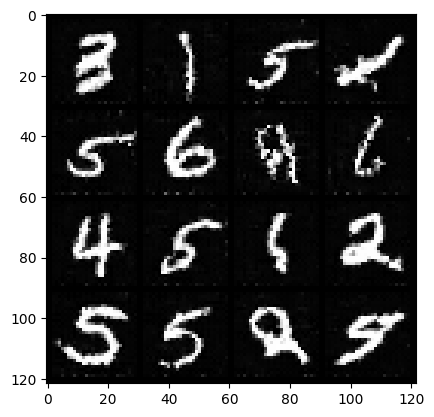

In [ ]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images
!pip install torch torchvision torchaudio
import torch
noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)